In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import os
# os.chdir('../Network-analysis/')
import utilities as util
# os.chdir('../src/')

['c:\\Users\\Vince\\OneDrive\\Documenten\\School\\TU\\2223\\modelling-networks-and-data-analysis\\project_higgs\\higgs-twitter-network-science\\src', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39', '', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\users\\vince\\projects\\fantoom\\emmel\\basy-synths', 'c:\\users\\vince\\projects\\fantoom\\emmel\\evairy', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\IPy

In [2]:
def create_subgraphs():
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../network-data/higgs-activity_time.txt"
    activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])

    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    # activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
    # .to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    # Swap source and target columns in the retweet dataset to effectively simulate the dataflow (as mentioned on the website)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=60*60):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # subgraph_df['timestamp'] = ((subgraph_df['timestamp'] - min_t)).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df

def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
        # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

def simulate_spreading(graph_df, social_network_df, seed_node, start_timestamp, end_timestamp, number_of_component_nodes=None, number_of_total_nodes=None, name="name_not_given", plot=True, title=""):

    graph_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    social_graph_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)

    graph_nodes[np.concatenate((np.array(graph_df['source'].unique()), np.array(graph_df['target'].unique())))] = 1
    if number_of_component_nodes is None:
        number_of_component_nodes = graph_nodes.sum()

    social_graph_nodes[np.concatenate((np.array(social_network_df['source'].unique()), np.array(social_network_df['target'].unique())))] = 1
    if number_of_total_nodes is None:
        number_of_total_nodes = social_graph_nodes.sum()

    spreading_start_time = graph_df[graph_df['source'] == seed_node]['timestamp'].min()
    min_timestamp = start_timestamp
    max_timestamp = end_timestamp
    # Get the number of nodes in the graph
    infected_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)

    infected_social_nodes =  np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    infected_nodes_time = [infected_nodes.sum()/number_of_component_nodes]
    infected_social_nodes_time = [infected_social_nodes.sum()/number_of_total_nodes]
    # Iterate over all timestamps
    for timestamp in range(min_timestamp, max_timestamp+1):
        if timestamp == spreading_start_time:
            infected_nodes[seed_node] = 1
            infected_social_nodes[seed_node] = 1
            infected_social_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes *= graph_nodes
        print(f'Graph: {name} Timestamp: {timestamp}/{max_timestamp} --- ', end='\r')

        # For each timestamp get the edges that were created on that timestamp
        edges = graph_df[graph_df['timestamp'] == timestamp]
        # Take the dataframe subset where the source  is in the infected nodes
        susceptible_nodes= edges[(infected_nodes[edges['source']] == 1)]['target']
        # Add the susceptible nodes to the infected nodes
        infected_social_nodes[susceptible_nodes] = 1
        # Add nodes to the informed nodes that are connected to the infected nodes
        susceptible_social_nodes = social_network_df[social_network_df['target'].isin(susceptible_nodes)]['source']
        infected_social_nodes[susceptible_social_nodes] = 1
        infected_nodes = infected_social_nodes * graph_nodes
        # Add the infected and informed nodes to the infected_nodes_time_dict
        infected_nodes_time.append(infected_nodes.sum()/number_of_component_nodes)
        infected_social_nodes_time.append(infected_social_nodes.sum()/number_of_total_nodes)

    # TODO: Add modelling of change in the number of infected and informed nodes

    # last_infected_n = 0
    # infected_nodes_new_it = []
    #
    # # add the difference between current infected and last infected
    # for inf_nodes in infected_nodes_time:
    #     n_inf = len(inf_nodes) - last_infected_n
    #     infected_nodes_new_it.append(n_inf/number_of_nodes)
    #     last_infected_n = len(inf_nodes)
    #
    # infected_nodes_ratio_time_count.append(infected_nodes_ratio_time_count_it)
    # infected_nodes_new.append(infected_nodes_new_it)
    #
    # # average over iterations
    # infected_nodes_ratio_time_count = np.mean(infected_nodes_ratio_time_count, axis=0)
    # infected_nodes_new = np.mean(infected_nodes_new, axis=0)

    if plot:
        x_range = np.arange(min_timestamp, max_timestamp+2)
        plt.plot(x_range, infected_nodes_time, label=f'{name}' + ' infected nodes', alpha=0.8)
        plt.plot(x_range, infected_social_nodes_time, label=f'{name}' + ' informed nodes', alpha=0.8)
        plt.title(title)
        plt.xlabel('Time (each time unit ≈ ' + str((24*7*60) // len(x_range)) + " minutes)")
        plt.ylabel('Ratio of nodes over all graph nodes')
        plt.legend()
    return infected_nodes, infected_social_nodes, infected_nodes_time, infected_social_nodes_time

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [3]:
create_subgraphs()

In [4]:
G_reply = nx.read_edgelist("../output/reply_timestamps.edgelist", nodetype=int, data=(('time',int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist("../output/mention_timestamps.edgelist", nodetype=int, data=(('time', int),),  create_using=nx.DiGraph)
G_retweet = nx.read_edgelist("../output/retweet_timestamps.edgelist", nodetype=int, data=(('time', int),), create_using=nx.DiGraph)
G_social = nx.read_edgelist("../network-data/higgs-social_network.edgelist", nodetype=int, create_using=nx.DiGraph)

G_reply_lcc = largest_connected_component(G_reply)
G_mention_lcc = largest_connected_component(G_mention)
G_retweet_lcc = largest_connected_component(G_retweet)

In [5]:
G_reply_lcc_df = build_df_from_graph(G_reply_lcc)
G_mention_lcc_df = build_df_from_graph(G_mention_lcc)
G_retweet_lcc_df = build_df_from_graph(G_retweet_lcc)

In [6]:
G_reply_df = build_df_from_graph(G_reply)
G_mention_df = build_df_from_graph(G_mention)
G_retweet_df = build_df_from_graph(G_retweet)

In [8]:

# G_social_df = build_social_network_df(G_social)
# is much faster:
G_social_df = pd.read_csv("../network-data/higgs-social_network.edgelist", sep = ' ',names=['source', 'target'])

In [10]:
print(G_retweet_lcc)
print(G_mention_lcc)
print(G_reply_lcc)
print(G_social)

DiGraph with 223833 nodes and 308596 edges
DiGraph with 91606 nodes and 132068 edges
DiGraph with 12839 nodes and 14944 edges
DiGraph with 456626 nodes and 14855842 edges


In [12]:
def get_nodes_by_centrality(network, n_nodes, start=0, metric='out_degree'):
    centr = None
    if metric == 'out_degree':
        centr = dict(network.out_degree())
    elif metric == 'in_degree':
        centr = dict(network.in_degree())
    elif metric == 'social_in_degree':
        centr = dict(G_social.in_degree(network.nodes()))
    elif metric == 'eigen':
        centr = nx.eigenvector_centrality(network)
    # Not tested
    elif metric == 'betweenness':
        centr = nx.betweenness_centrality(network)
    # Not tested
    elif metric == 'pagerank':
        centr = nx.pagerank(network)
    # Not tested
    elif metric == 'hits_authority':
        h, a = nx.hits(network)
        centr = a
    # Not tested
    elif metric == 'hits_hub':
        h, a = nx.hits(network)
        centr = h
    else:
        raise ValueError('Unknown centrality metric') 

    sorted_nodes = sorted(centr.items(), key=lambda x: x[1], reverse=True)
    return [v[0] for v in sorted_nodes[start:start+n_nodes]]  


In [13]:
n_nodes = 10
reply_graph_name ="reply"
retweet_graph_name ="retweet"
mention_graph_name ="mention"

out_degree_name = "max " + str(n_nodes) + " out_degree nodes"

max_out_degree_reply = get_nodes_by_centrality(G_reply, n_nodes, metric='out_degree')
max_out_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric='out_degree')
max_out_degree_mention = get_nodes_by_centrality(G_mention, n_nodes, metric='out_degree')

# util.print_and_log(reply_graph_name, out_degree_name, max_out_degree_reply)
# util.print_and_log(retweet_graph_name, out_degree_name, max_out_degree_retweet)
# util.print_and_log(mention_graph_name, out_degree_name, max_out_degree_mention)

In [45]:
eigen_name = "max " + str(n_nodes) + " eigencentrality nodes"

max_eigen_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="eigen")
max_eigen_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="eigen")
max_eigen_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="eigen")

# util.print_and_log(reply_graph_name, eigen_name, max_eigen_reply)
# util.print_and_log(retweet_graph_name, eigen_name, max_eigen_retweet)
# util.print_and_log(mention_graph_name, eigen_name, max_eigen_mention)


(reply) max 10 eigencentality nodes: [9021, 33833, 35376, 50244, 86903, 50228, 109175, 134319, 86725, 77555]
(retweet) max 10 eigencentality nodes: [53508, 64911, 35376, 206362, 103447, 39885, 182906, 75798, 28951, 76165]
(mention) max 10 eigencentality nodes: [89805, 67382, 12751, 26158, 110903, 98204, 20385, 511, 1276, 492]


In [14]:
in_degree_name = "max " + str(n_nodes) + " in_degree nodes"

max_in_degree_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="in_degree")
max_in_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="in_degree")
max_in_degree_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="in_degree")

# util.print_and_log(reply_graph_name, in_degree_name, max_in_degree_reply)
# util.print_and_log(retweet_graph_name, in_degree_name, max_in_degree_retweet)
# util.print_and_log(mention_graph_name, in_degree_name, max_in_degree_mention)

"""betweenness_name = "max " + str(n_nodes) + " betweenness nodes"

max_betweenness_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="betweenness")
max_betweenness_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="betweenness")
max_betweenness_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="betweenness")

util.print_and_log(reply_graph_name, betweenness_name, max_betweenness_reply)
util.print_and_log(retweet_graph_name, betweenness_name, max_betweenness_retweet)
util.print_and_log(mention_graph_name, betweenness_name, max_betweenness_mention)"""


(reply) max 10 in_degree nodes: [9021, 16695, 433454, 359985, 6241, 113517, 67382, 52908, 72466, 20971]
(retweet) max 10 in_degree nodes: [38535, 181190, 81405, 64911, 54301, 27705, 53508, 232850, 492, 62391]
(mention) max 10 in_degree nodes: [89805, 26158, 1276, 9021, 6241, 492, 149922, 4665, 67382, 12751]


'betweenness_name = "max " + str(n_nodes) + " betweenness nodes"\n\nmax_betweenness_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="betweenness")\nmax_betweenness_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="betweenness")\nmax_betweenness_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="betweenness")\n\nutil.print_and_log(reply_graph_name, betweenness_name, max_betweenness_reply)\nutil.print_and_log(retweet_graph_name, betweenness_name, max_betweenness_retweet)\nutil.print_and_log(mention_graph_name, betweenness_name, max_betweenness_mention)'

In [15]:
social_in_degree_name = "max " + str(n_nodes) + " social_in_degree nodes"
# basically the number of followers
max_social_in_degree_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="social_in_degree")
max_social_in_degree_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="social_in_degree")
max_social_in_degree_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="social_in_degree")


'betweenness_name = "max " + str(n_nodes) + " betweenness nodes"\n\nmax_betweenness_reply = get_nodes_by_centrality(G_reply, n_nodes, metric="betweenness")\nmax_betweenness_retweet = get_nodes_by_centrality(G_retweet, n_nodes, metric="betweenness")\nmax_betweenness_mention = get_nodes_by_centrality(G_mention, n_nodes, metric="betweenness")\n\nutil.print_and_log(reply_graph_name, betweenness_name, max_betweenness_reply)\nutil.print_and_log(retweet_graph_name, betweenness_name, max_betweenness_retweet)\nutil.print_and_log(mention_graph_name, betweenness_name, max_betweenness_mention)'

In [16]:
start_timestamp, end_timestamp = get_start_end_combined(G_reply_lcc_df, G_mention_lcc_df, G_retweet_lcc_df)
print(start_timestamp)
print(end_timestamp)

0
167


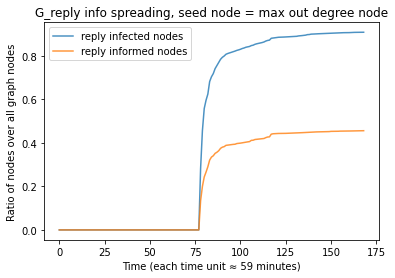

In [17]:
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df,\
            G_social_df, max_social_in_degree_reply[0], start_timestamp, end_timestamp, name="reply", plot=True, title="G_reply info spreading, seed node = max social in degree node")

[ 18038 213163  33833 ...  34216 223125  97296]


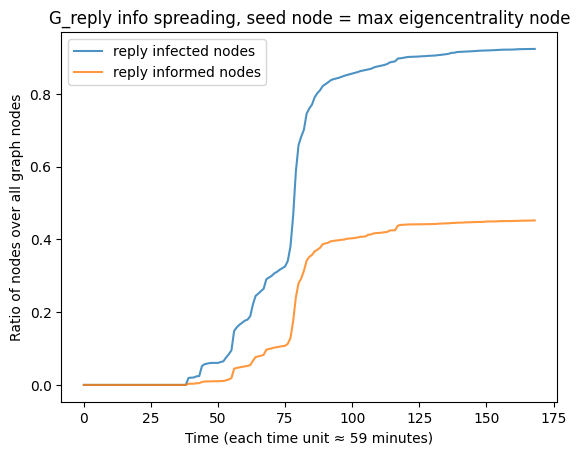

In [108]:
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df,\
            G_social_df, max_eigen_reply[0], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()),\
            len(G_social.nodes()), name="reply", plot=True, title="G_reply info spreading, seed node = max eigencentrality node")

[ 18038 213163  33833 ...  34216 223125  97296]


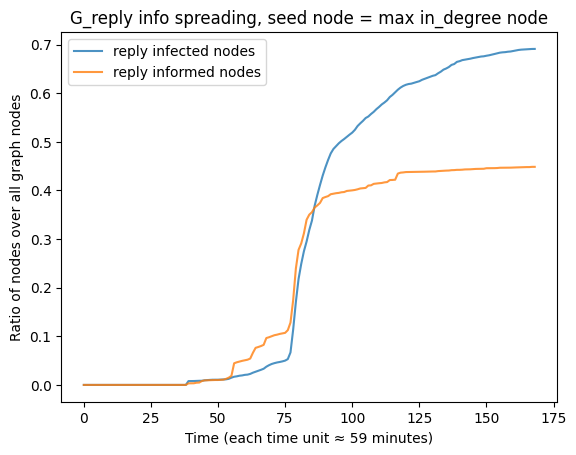

In [59]:
infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(G_reply_lcc_df,\
            G_social_df, max_in_degree_reply[0], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()),\
            len(G_social.nodes()), name="reply", plot=True, title="G_reply info spreading, seed node = max in_degree node")

In [19]:
def simulate_spreading_n_nodes(graph_df, social_network_df, seed_nodes, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name="name_not_given", plot=True, title=""):
    
    infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n = [], [], [], []
    top_label = 1
    for node in seed_nodes:
        infected_nodes, informed_nodes, infected_nodes_time, informed_nodes_time = simulate_spreading(\
                graph_df, social_network_df, node, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name= name + " top" + str(top_label), plot=plot, title=title)
        
        infected_nodes_n.append(infected_nodes)
        informed_nodes_n.append(informed_nodes)
        infected_nodes_time_n.append(infected_nodes_time)
        informed_nodes_time_n.append(informed_nodes_time)
        top_label += 1
        
    return infected_nodes_n, informed_nodes_n, infected_nodes_time_n, informed_nodes_time_n

In [20]:
def cum_to_diff(time):
    return np.array(time[1:]) - np.array(time[:-1])

In [21]:
def get_crosscorr(proc_n_1, proc_n_2):
    return np.mean([np.correlate(cum_to_diff(proc_1), cum_to_diff(proc_2), 'full') for proc_1, proc_2 in zip(proc_n_1, proc_n_2)], axis=0)

print(max_out_degree_reply[:3])

[677, 88, 220]


(reply) baselineinfected_nodes_n: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
(reply) baselineinformed_nodes_n: [array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 1.,

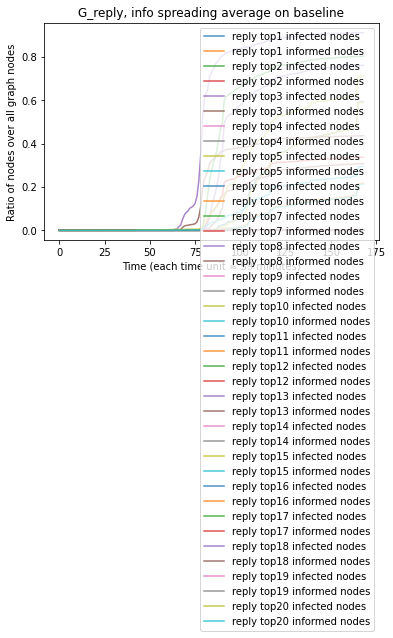

In [33]:
baseline_nodes = np.random.choice(G_reply_lcc.nodes(), 20)

# Info spreading for top 3 out_degree nodes for G_reply
infected_nodes_n_rep_out_deg, informed_nodes_n_rep_out_deg, infected_nodes_time_rep_out_deg, informed_nodes_time_rep_out_deg = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, baseline_nodes, start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True, title="G_reply, info spreading average on baseline")
metric_name = "baseline_"
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_rep_out_deg)

(reply) top3_out_degree_infected_nodes_n: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
(reply) top3_out_degree_informed_nodes_n: [array([0., 0., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.])]
(reply) top3_out_degree_infected_nodes_time: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28296596308123684, 0.45603240127735806, 0.5573642807072202, 0.5952955837682062, 0.6236467014564997, 0.6812835890645689, 0.7031700288184438, 0.7177350260923748, 0.7404003427058182, 0.7549653399797492, 0.7693745618817664, 0.7832385699820859, 0.79235

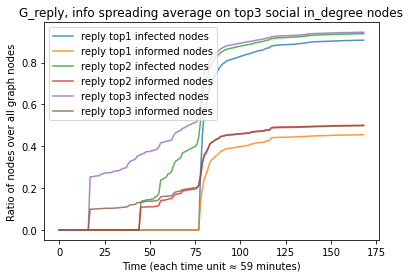

In [22]:
# Info spreading for top 3 out_degree nodes for G_reply
infected_nodes_n_rep_out_deg, informed_nodes_n_rep_out_deg, infected_nodes_time_rep_out_deg, informed_nodes_time_rep_out_deg = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_social_in_degree_reply[:3], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True, title="G_reply, info spreading average on top3 social in_degree nodes")
metric_name = "top3_out_degree_"
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_rep_out_deg)

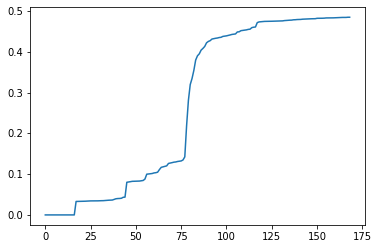

In [26]:
plt.plot(np.mean(informed_nodes_time_rep_out_deg,axis=0))

### Reply


[ 18038 213163  33833 ...  34216 223125  97296]
[ 18038 213163  33833 ...  34216 223125  97296]
[ 18038 213163  33833 ...  34216 223125  97296]
(reply) top3_out_degreeinfected_nodes_n: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
(reply) top3_out_degreeinformed_nodes_n: [array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 1., 0.])]
(reply) top3_out_degreeinfected_nodes_time_rep: [[0.0, 0.0, 0.26481813225329076, 0.26481813225329076, 0.2648960199392476, 0.2648960199392476, 0.2648960199392476, 0.2648960199392476, 0.2648960199392476, 0.26497390762520445, 0.2650517953111613, 0.26512968299711814, 0.265207570683075, 0.2653633460549887, 0.2653633460549887, 0.2653633460549887, 0.2653633460549887, 0.2654412337409456, 0.2655970091128593, 0.26590855985668665, 0.2663758859724278, 0.26668743671625517, 0.26684321208816886, 0.26715476283199624, 0.26731053820391, 0.26738842588986683

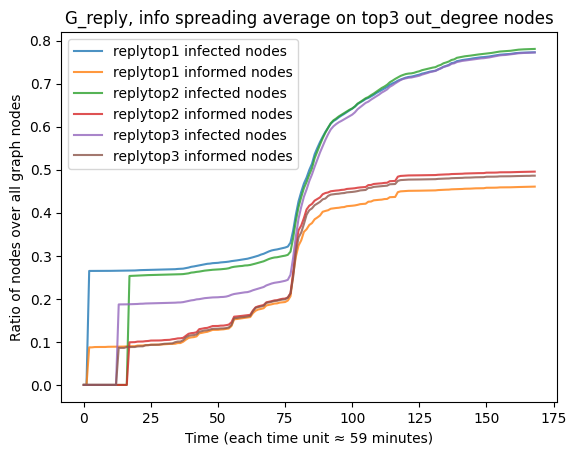

In [76]:
# Info spreading for top 3 out_degree nodes for G_reply
infected_nodes_n_rep_out_deg, informed_nodes_n_rep_out_deg, infected_nodes_time_rep_out_deg, informed_nodes_time_rep_out_deg = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_out_degree_reply[:3], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True, title="G_reply, info spreading average on top3 out_degree nodes")
metric_name = "top3_out_degree_"
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_rep_out_deg)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_rep_out_deg)

### Retweet

[ 50329    463  93318 ... 101208  16017  51305]
[ 50329    463  93318 ... 101208  16017  51305]
[ 50329    463  93318 ... 101208  16017  51305]
(retweet) top3_out_degree_infected_nodes_n: [array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.])]
(retweet) top3_out_degree_informed_nodes_n: [array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.])]
(retweet) top3_out_degree_infected_nodes_time: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12898455544982196, 0.12901136114871356, 0.12902476399815935, 0.129047102080569, 0.12909624586187024, 0.12913198679372567, 0.1295698132089549, 0.13007018625493114, 0.13028463184606381, 0.13044993365589524, 0.13086095437223286, 0.13130771602042593, 0.13151322637859475, 0.13161151394119724, 0.13173660720269129, 0.13184382999825764, 0.1319108442454866, 0.1320001965751252, 0.13212082222013732, 0.13225485071459525, 0.13242015252442668, 0.1

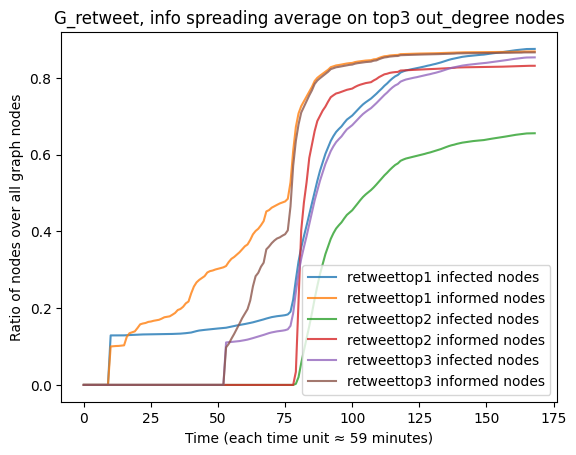

In [77]:
# Info spreading for top 3 out_degree nodes for G_retweet
infected_nodes_n_ret_out_deg, informed_nodes_n_ret_out_deg, infected_nodes_time_ret_out_deg, informed_nodes_time_ret_out_deg = simulate_spreading_n_nodes(G_retweet_lcc_df, G_social_df, max_out_degree_retweet[:3], start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True, title="G_retweet, info spreading average on top3 out_degree nodes")
metric_name = "top3_out_degree_"
util.print_and_log(retweet_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_ret_out_deg)
util.print_and_log(retweet_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_ret_out_deg)
util.print_and_log(retweet_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_ret_out_deg)
util.print_and_log(retweet_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_ret_out_deg)

[213163    511   2417 ... 214170  97296 338829]
[213163    511   2417 ... 214170  97296 338829]
[213163    511   2417 ... 214170  97296 338829]


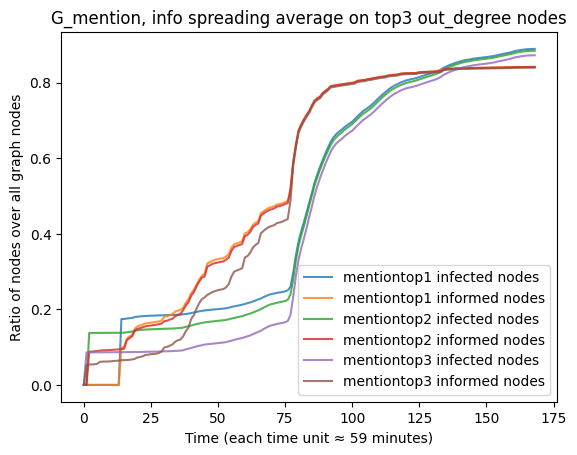

In [75]:
# Info spreading for top 3 out_degree nodes for G_mention
infected_nodes_n_men_out_deg, informed_nodes_n_men_out_deg, infected_nodes_time_men_out_deg, informed_nodes_time_men_out_deg = simulate_spreading_n_nodes(G_mention_lcc_df, G_social_df, max_out_degree_mention[:3], start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True, title="G_mention, info spreading average on top3 out_degree nodes")
metric_name = "top3_out_degree_"
util.print_and_log(mention_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_men_out_deg)
util.print_and_log(mention_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_men_out_deg)
util.print_and_log(mention_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_men_out_deg)
util.print_and_log(mention_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_men_out_deg)

### Mention

[ 18038 213163  33833 ...  34216 223125  97296]
[ 18038 213163  33833 ...  34216 223125  97296]
[ 18038 213163  33833 ...  34216 223125  97296]


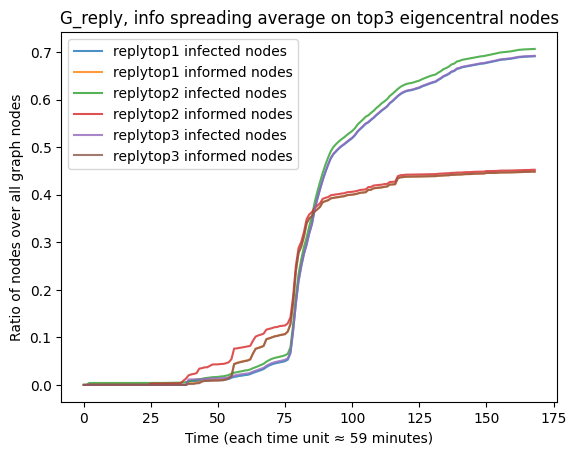

In [73]:
# Info spreading for top 3 eigencentrality nodes for G_Reply
infected_nodes_n_rep_eigen, informed_nodes_n_men_rep_eigen, infected_nodes_time_rep_eigen, informed_nodes_time_rep_eigen = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_eigen_reply[:3], start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True, title="G_reply, info spreading average on top3 eigencentral nodes")
metric_name = "top3_eigen_"
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_rep_eigen)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_men_rep_eigen)
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_rep_eigen)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_rep_eigen)

In [ ]:
# Info spreading for top 3 eigencentrality nodes for G_retweet
infected_nodes_n_ret_eigen, informed_nodes_n_ret_eigen, infected_nodes_time_ret_eigen, informed_nodes_time_ret_eigen = simulate_spreading_n_nodes(G_retweet_lcc_df, G_social_df, max_eigen_retweet[:3], start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True, title="G_retweet, info spreading average on top3 eigencentral nodes")
metric_name = "top3_eigen_"
util.print_and_log(retweet_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_ret_eigen)
util.print_and_log(retweet_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_ret_eigen)
util.print_and_log(retweet_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_ret_eigen)
util.print_and_log(retweet_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_ret_eigen)

In [ ]:
# Info spreading for top 3 eigencentrality nodes for G_mention
infected_nodes_n_men_eigen, informed_nodes_n_men_eigen, infected_nodes_time_men_eigen, informed_nodes_time_men_eigen = simulate_spreading_n_nodes(G_mention_lcc_df, G_social_df, max_eigen_mention[:3], start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True, title="G_mention, info spreading average on top3 eigencentral nodes")
metric_name = "top3_eigen_"
util.print_and_log(mention_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_men_eigen)
util.print_and_log(mention_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_men_eigen)
util.print_and_log(mention_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_men_eigen)
util.print_and_log(mention_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_men_eigen)

(mention) top3_followers_infected_nodes_n: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
(mention) top3_followers_informed_nodes_n: [array([0., 0., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.])]
(mention) top3_followers_infected_nodes_time: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039658974302993255, 0.06391502739995197, 0.07811715389821627, 0.08343339955898085, 0.08740693841014781, 0.09548501189878392, 0.09855249656136061, 0.10059384756457, 0.10377049538239853, 0.10581184638560794, 0.10783136475776696, 0.109774468921249

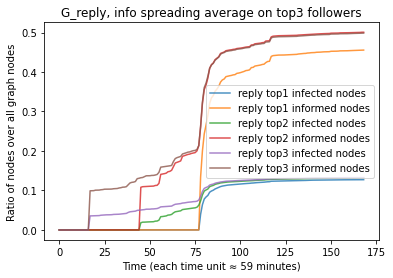

In [55]:
infected_nodes_n_men_eigen, informed_nodes_n_men_eigen, infected_nodes_time_men_eigen, informed_nodes_time_men_eigen = simulate_spreading_n_nodes(G_reply_lcc_df, G_social_df, max_social_in_degree_reply[:3], start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True, title="G_reply, info spreading average on top3 followers")
metric_name = "top3_followers_"
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_n", infected_nodes_n_men_eigen)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_n", informed_nodes_n_men_eigen)
util.print_and_log(reply_graph_name, metric_name + "infected_nodes_time", infected_nodes_time_men_eigen)
util.print_and_log(reply_graph_name, metric_name + "informed_nodes_time", informed_nodes_time_men_eigen)

In [ ]:
cutoff = 90
corr = get_crosscorr(informed_nodes_time_rep[cutoff:], informed_nodes_time_ret[cutoff:])

In [ ]:
plt.plot(corr)

In [60]:
import importlib
importlib.reload(util)

['c:\\Users\\Vince\\OneDrive\\Documenten\\School\\TU\\2223\\modelling-networks-and-data-analysis\\project_higgs\\higgs-twitter-network-science\\src', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39', '', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\users\\vince\\projects\\fantoom\\emmel\\basy-synths', 'c:\\users\\vince\\projects\\fantoom\\emmel\\evairy', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Vince\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\IPy

<module 'utilities' from 'c:\\Users\\Vince\\OneDrive\\Documenten\\School\\TU\\2223\\modelling-networks-and-data-analysis\\project_higgs\\higgs-twitter-network-science\\src\\utilities.py'>

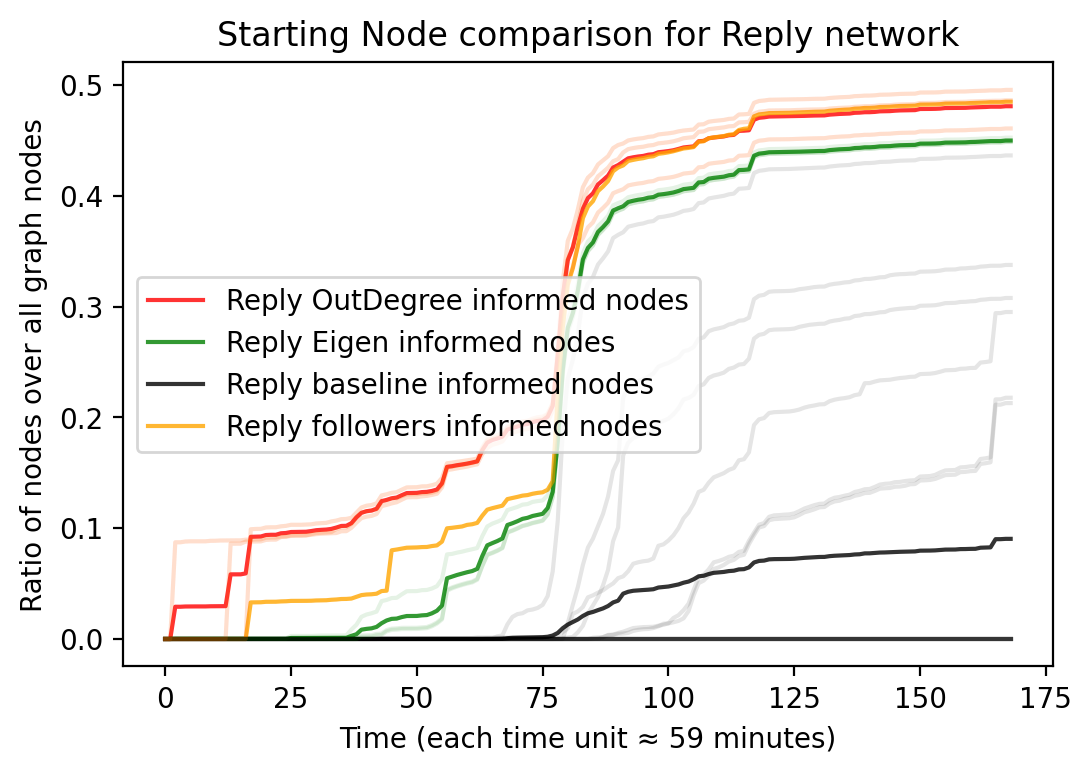

In [61]:
plt.figure(dpi=200)
util.plot_all_graph_metrics('../log/reply.csv',0,167, "Reply")